In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import Imputer

%matplotlib inline

In [5]:
pd.set_option('display.max_columns', 100)

mpl.rc(group='figure', figsize=(10,8))
plt.style.use('seaborn')

## Load the train dataset, train labels, and test dataset
* Convert the week_start_date column into a datetimestamp so we can perform some time series analysis.

In [65]:
filepath = 'dataset'
X_train = pd.read_csv(filepath + '/dengue_features_train.csv')
X_train.week_start_date = pd.to_datetime(X_train.week_start_date)
print(f'X_train: {X_train.shape}')

y_train = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv', 
                      usecols=['total_cases'])
print(f'y_train: {y_train.shape}')

X_test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv')
X_test.week_start_date = pd.to_datetime(X_test.week_start_date)
print(f'X_test: {X_test.shape}')

X_train: (1456, 24)
y_train: (1456, 1)
X_test: (416, 24)


In [7]:
X_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [8]:
y_train.head()

,total_cases
0,4
1,5
2,4
3,3
4,6


In [9]:
X_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


## Combine the train dataset and the train labels

In [38]:
Xy_train = pd.concat([y_train, X_train], axis=1) 
print(f'Xy_train: {Xy_train.shape}')
Xy_train.head()

Xy_train: (1456, 26)


,total_cases,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,4,0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,5,1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,4,2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,3,3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,6,4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


## Split the combined train dataset into separate San Juan and Iquitos datasets

In [39]:
Xy_sj = Xy_train.loc[Xy_train.city == 'sj', :]
Xy_iq = Xy_train.loc[Xy_train.city == 'iq', :]
print(f'Xy_sj: {Xy_sj.shape}')
print(f'Xy_iq: {Xy_iq.shape}')

Xy_sj: (936, 26)
Xy_iq: (520, 26)


## Correlations between total_cases and the features

### San Juan

In [40]:
Xy_sj.corr().total_cases.sort_values(ascending=False)

total_cases                              1.000000
weekofyear                               0.287134
reanalysis_specific_humidity_g_per_kg    0.207947
reanalysis_dew_point_temp_k              0.203774
station_avg_temp_c                       0.196617
reanalysis_max_air_temp_k                0.194532
station_max_temp_c                       0.189901
reanalysis_min_air_temp_k                0.187943
reanalysis_air_temp_k                    0.181917
station_min_temp_c                       0.177012
reanalysis_avg_temp_k                    0.175267
reanalysis_relative_humidity_percent     0.144045
reanalysis_precip_amt_kg_per_m2          0.107457
ndvi_nw                                  0.075307
reanalysis_sat_precip_amt_mm             0.060211
precipitation_amt_mm                     0.060211
station_precip_mm                        0.051759
ndvi_ne                                  0.037639
station_diur_temp_rng_c                  0.034630
ndvi_se                                  0.001113


### Iquitos

In [41]:
Xy_iq.corr().total_cases.sort_values(ascending=False)

total_cases                              1.000000
reanalysis_specific_humidity_g_per_kg    0.236476
reanalysis_dew_point_temp_k              0.230401
reanalysis_min_air_temp_k                0.214514
station_min_temp_c                       0.211702
index                                    0.180166
year                                     0.179451
reanalysis_relative_humidity_percent     0.130083
station_avg_temp_c                       0.113070
reanalysis_precip_amt_kg_per_m2          0.101171
reanalysis_air_temp_k                    0.097098
precipitation_amt_mm                     0.090171
reanalysis_sat_precip_amt_mm             0.090171
reanalysis_avg_temp_k                    0.079872
station_max_temp_c                       0.075279
station_precip_mm                        0.042976
ndvi_sw                                  0.032999
ndvi_ne                                  0.020215
ndvi_nw                                 -0.009586
weekofyear                              -0.011850


## In San Juan there is a pattern of peaks in total cases every 52 weeks or so. There are similar patterns of peaks in dew point temp, specific humidity, min/avg/max temperature, and precipitation.

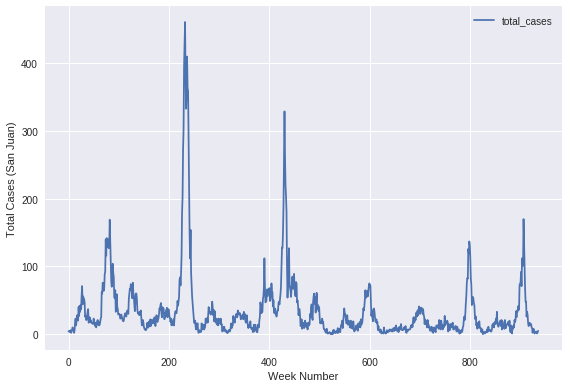

In [42]:
Xy_sj.total_cases.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Total Cases (San Juan)')
plt.legend()
plt.tight_layout()

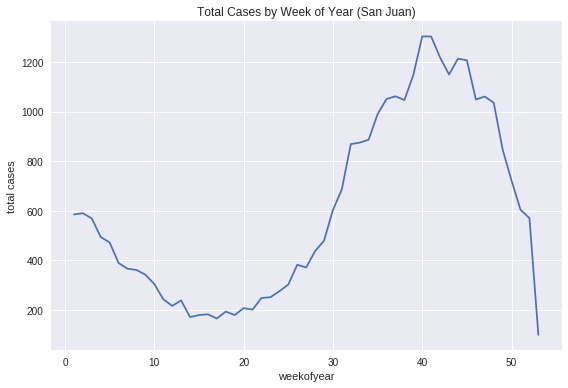

In [43]:
Xy_sj.groupby(['weekofyear']).total_cases.sum().plot(kind='line')
plt.ylabel('total cases')
plt.title('Total Cases by Week of Year (San Juan)')
plt.tight_layout()

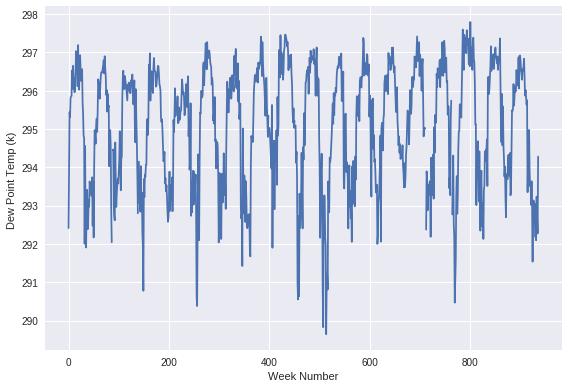

In [44]:
Xy_sj.reanalysis_dew_point_temp_k.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Dew Point Temp (k) ')
plt.tight_layout()

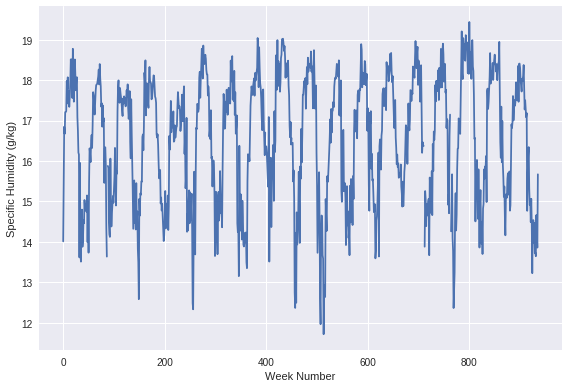

In [45]:
Xy_sj.reanalysis_specific_humidity_g_per_kg.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Specific Humidity (g/kg)')
plt.tight_layout()

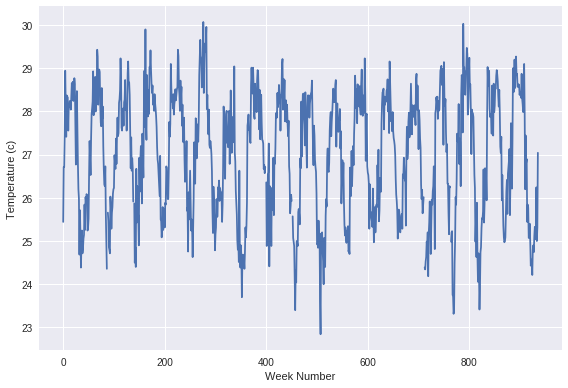

In [46]:
Xy_sj.station_avg_temp_c.plot(kind='line')
plt.xlabel('Week Number')
plt.ylabel('Temperature (c)')
plt.tight_layout()

## Practically every feature has some missing values

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
index                                    1456 non-null int64
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null datetime64[ns]
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_

## Use reset_index to save the index so we can easily restore the dataset to its original order.

In [48]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

## Split the train dataset into San Juan and Iquitos datasets

In [49]:
X_train_sj = X_train.loc[X_train.city == 'sj', :].copy()
X_train_iq = X_train.loc[X_train.city == 'iq', :].copy()

y_train_sj = y_train.loc[X_train.city == 'sj', :].copy()
y_train_iq = y_train.loc[X_train.city == 'iq', :].copy()

print(f'X_train_sj: {X_train_sj.shape}')
print(f'X_train_iq: {X_train_iq.shape}')
print(f'y_train_sj: {y_train_sj.shape}')
print(f'y_train_iq: {y_train_iq.shape}')

X_train_sj: (936, 26)
X_train_iq: (520, 26)
y_train_sj: (936, 1)
y_train_iq: (520, 1)


## Split the test dataset into San Juan and Iquitos datasets

In [50]:
X_test_sj = X_test.loc[X_test.city == 'sj', :].copy()
X_test_iq = X_test.loc[X_test.city == 'iq', :].copy()
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_test_sj: (260, 26)
X_test_iq: (156, 26)


## We are only going to use some of the features. We will use time series analysis to create some new features.

In [51]:
keys = ['city', 'year', 'weekofyear']

all_features = ['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']

features = ['reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_specific_humidity_g_per_kg', 
            'station_avg_temp_c',  'station_max_temp_c', 'station_min_temp_c']

new_features = ['recent_mean_dew_point', 'recent_mean_spec_humid', 'recent_sum_precip']

time_series_features = ['week_start_date']

drop_features = list(set(all_features) - set(features) - set(keys) - set(time_series_features))
print('drop_features:\n', sorted(drop_features))

drop_features:
 ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_precip_mm']


## Impute missing values
* Take advantage of redundant temperature features to impute missing temperature values. 
* Impute missing values in other features using the feature mean. 

In [52]:
impute_columns = ['reanalysis_avg_temp_c', 'reanalysis_max_air_temp_c', 
                  'reanalysis_min_air_temp_c']

def impute_redundant_features(df):
    # Convert temperature from kelvin to celcius so we can attempt to correct 
    # for the difference between the two redundant temperature features 
    # (i.e. reanalysis and station).
    df['reanalysis_avg_temp_c'] = df.reanalysis_avg_temp_k - 273.15
    # mean will return a single value
    df.reanalysis_avg_temp_c -= (df.reanalysis_avg_temp_c - df.station_avg_temp_c).mean()
    df.loc[df.station_avg_temp_c.isnull(), 'station_avg_temp_c'] = df.reanalysis_avg_temp_c

    df['reanalysis_max_air_temp_c'] = df.reanalysis_max_air_temp_k - 273.15
    df.reanalysis_max_air_temp_c -= (df.reanalysis_max_air_temp_c - df.station_max_temp_c).mean()
    df.loc[df.station_max_temp_c.isnull(), 'station_max_temp_c'] = df.reanalysis_max_air_temp_c

    df['reanalysis_min_air_temp_c'] = df.reanalysis_min_air_temp_k - 273.15
    df.reanalysis_min_air_temp_c -= (df.reanalysis_min_air_temp_c - df.station_min_temp_c).mean()
    df.loc[df.station_min_temp_c.isnull(), 'station_min_temp_c'] = df.reanalysis_min_air_temp_c
    
    # Drop the temporary columns that we just added
    df.drop(impute_columns, axis=1, inplace=True)
    
    return df

In [53]:
X_train_sj = impute_redundant_features(X_train_sj)
X_train_iq = impute_redundant_features(X_train_iq)

X_test_sj = impute_redundant_features(X_test_sj)
X_test_iq = impute_redundant_features(X_test_iq)

In [54]:
def impute_missing_values(df, imputer):
    imputer.fit(df[features])
    df[features] = imputer.transform(df[features])
    return df

In [55]:
imputer_sj = Imputer(strategy='mean')
X_train_sj = impute_missing_values(X_train_sj, imputer_sj)
X_test_sj = impute_missing_values(X_test_sj, imputer_sj)

imputer_iq = Imputer(strategy='mean')
X_train_iq = impute_missing_values(X_train_iq, imputer_iq)
X_test_iq = impute_missing_values(X_test_iq, imputer_iq)

## Engineer new features
* The cumulative effect of prior weeks might impact the number of dengue fever cases in subsequent weeks.
* Use time series on dew point, humidity, and precipitation.

In [56]:
def add_time_series_features(df, window):
    df.set_index('week_start_date', inplace=True)

    roll_df = df.rolling(window=window, min_periods=1)
    df['recent_mean_dew_point'] = roll_df.reanalysis_dew_point_temp_k.mean()
    df['recent_mean_spec_humid'] = roll_df.reanalysis_specific_humidity_g_per_kg.mean()
    df['recent_sum_precip'] = roll_df.reanalysis_precip_amt_kg_per_m2.sum()
    
    df.reset_index(inplace=True)    
    return df

## Through a little experimentation a 100 day rolling window for San Juan and 30 day rolling window for Iquitos appear to work the best

In [57]:
X_train_sj = add_time_series_features(X_train_sj, window=100)
X_train_iq = add_time_series_features(X_train_iq, window=30)
X_test_sj = add_time_series_features(X_test_sj, window=100)
X_test_iq = add_time_series_features(X_test_iq, window=30)

print(f'X_train_sj: {X_train_sj.shape}')
print(f'X_train_iq: {X_train_iq.shape}')
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_train_sj: (936, 29)
X_train_iq: (520, 29)
X_test_sj: (260, 29)
X_test_iq: (156, 29)


## Drop features which are no longer needed

In [58]:
def drop_unnecessary_features(df):
    df.drop(drop_features, axis=1, inplace=True)
    df.drop(time_series_features, axis=1, inplace=True)
    return df

In [59]:
X_train_sj = drop_unnecessary_features(X_train_sj)
X_train_iq = drop_unnecessary_features(X_train_iq)
X_test_sj = drop_unnecessary_features(X_test_sj)
X_test_iq = drop_unnecessary_features(X_test_iq)

print(f'X_train_sj: {X_train_sj.shape}')
print(f'X_train_iq: {X_train_iq.shape}')
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_train_sj: (936, 14)
X_train_iq: (520, 14)
X_test_sj: (260, 14)
X_test_iq: (156, 14)


## Normalize the feature values
* Convert them to z-scores

In [60]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

In [61]:
features_to_normalize = features + new_features

X_train_sj[features_to_normalize] = X_train_sj[features_to_normalize].apply(normalize, axis=0)
X_train_iq[features_to_normalize] = X_train_iq[features_to_normalize].apply(normalize, axis=0)
X_test_sj[features_to_normalize] = X_test_sj[features_to_normalize].apply(normalize, axis=0)
X_test_iq[features_to_normalize] = X_test_iq[features_to_normalize].apply(normalize, axis=0)

## Put the San Juan and Iquitos datasets back into one dataset
* Restore the index to its original values

In [62]:
X_train = pd.concat([X_train_sj, X_train_iq], axis=0)
X_train.set_index('index', inplace=True)
X_train.head()

,level_0,city,year,weekofyear,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_max_temp_c,station_min_temp_c,recent_mean_dew_point,recent_mean_spec_humid,recent_sum_precip
index,,,,,,,,,,,,,
0,0,sj,1990,18,-1.722306,0.043211,-1.632200,-1.108260,-1.289862,-1.732105,-9.463572,-8.929043,-3.733679
1,1,sj,1990,19,-0.740042,-0.352694,-0.758112,-0.207129,0.053770,-0.266841,-6.794441,-6.566003,-3.710537
2,2,sj,1990,20,0.207532,-0.122923,0.190347,-0.207129,0.345864,0.132776,-4.188151,-4.068925,-3.676869
3,3,sj,1990,21,0.128111,-0.466453,0.077414,0.329500,0.988471,0.465791,-2.992913,-2.973040,-3.658939
4,4,sj,1990,22,0.454924,-0.514322,0.422642,1.372383,1.981591,0.865408,-1.920547,-1.942189,-3.643202


## Split the train dataset into separate San Juan and Iquitos datasets

In [63]:
X_sj, y_sj = X_train.loc[X_train.city == 'sj', :], y_train.loc[X_train.city == 'sj', :]
X_iq, y_iq = X_train.loc[X_train.city == 'iq', :], y_train.loc[X_train.city == 'iq', :]
print(f'X_sj: {X_sj.shape}')
print(f'y_sj: {y_sj.shape}')
print(f'X_iq: {X_iq.shape}')
print(f'y_iq: {y_iq.shape}')

X_sj: (936, 13)
y_sj: (936, 1)
X_iq: (520, 13)
y_iq: (520, 1)


## Split training datasets into training dataset and cross validation datasets

In [33]:
X_train_sj, X_cross_sj, y_train_sj, y_cross_sj = train_test_split(X_sj, 
                                                                  y_sj,
                                                                  test_size=0.2,
                                                                  stratify=X_sj.weekofyear)

print(f'X_train_sj: {X_train_sj.shape}')
print(f'y_train_sj: {y_train_sj.shape}')
print(f'X_cross_sj: {X_cross_sj.shape}')
print(f'y_cross_sj: {y_cross_sj.shape}')

X_train_sj: (748, 12)
y_train_sj: (748, 1)
X_cross_sj: (188, 12)
y_cross_sj: (188, 1)


In [34]:
X_train_iq, X_cross_iq, y_train_iq, y_cross_iq = train_test_split(X_iq, 
                                                                  y_iq, 
                                                                  test_size=0.2,
                                                                  stratify=X_iq.weekofyear)

print(f'X_train_iq: {X_train_iq.shape}')
print(f'y_train_iq: {y_train_iq.shape}')
print(f'X_cross_iq: {X_cross_iq.shape}')
print(f'y_cross_iq: {y_cross_iq.shape}')

X_train_iq: (416, 12)
y_train_iq: (416, 1)
X_cross_iq: (104, 12)
y_cross_iq: (104, 1)


## Drop the columns which we no longer need in the train and cross validation datasets
* dataset
* keys
* week_start_date

In [35]:
def drop_unnecessary_columns(df):
    return df[features + new_features + ['weekofyear']]

In [36]:
X_train_sj = drop_unnecessary_columns(X_train_sj)
X_train_iq = drop_unnecessary_columns(X_train_iq)
X_cross_sj = drop_unnecessary_columns(X_cross_sj)
X_cross_iq = drop_unnecessary_columns(X_cross_iq)

print(f'X_train_iq: {X_train_iq.shape}')
print(f'y_train_iq: {y_train_iq.shape}')
print(f'X_cross_iq: {X_cross_iq.shape}')
print(f'y_cross_iq: {y_cross_iq.shape}')

X_train_iq: (416, 10)
y_train_iq: (416, 1)
X_cross_iq: (104, 10)
y_cross_iq: (104, 1)


## Try dummy regressor for baseline

In [37]:
def train_predict_score(reg, X, y):
    reg.fit(X, y)
    y_pred = reg.predict(X)
    return mean_absolute_error(y_true=y, y_pred=y_pred)

In [38]:
reg = DummyRegressor(strategy='mean')
print('San Juan: ', round(train_predict_score(reg, X_train_sj, y_train_sj), 4))
print('Iquitos: ', round(train_predict_score(reg, X_train_iq, y_train_iq), 4))

San Juan:  27.636
Iquitos:  6.7742


## Try various regression algorithms to see which look most promising
* Linear Regression
* KNN
* SVM
* Gradient Boosting
* Random Forest
* MLP

In [39]:
def train_cross_val_score(reg, X, y, scoring='neg_mean_absolute_error'):
    reg.fit(X, y)
    scores = np.abs(cross_val_score(reg, X, y, scoring=scoring))
    print("Scores: {}".format(scores))
    print("Avg Score: {}".format(scores.mean()))

### Linear Regression

In [40]:
reg = LinearRegression(n_jobs=-1)
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq)

San Juan:
Scores: [25.42109429 29.86478555 25.67595414]
Avg Score: 26.987277994156766

Iquitos:
Scores: [6.69534904 5.99738813 6.92539021]
Avg Score: 6.539375793400022


### KNN

In [41]:
reg = KNeighborsRegressor(n_jobs=-1)
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq)

San Juan:
Scores: [27.0408     29.1253012  23.28032129]
Avg Score: 26.482140829986616

Iquitos:
Scores: [6.90647482 5.74244604 6.91449275]
Avg Score: 6.521137872310848


### SVM

In [42]:
reg = SVR(kernel='linear')
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

San Juan:
Scores: [19.34910318 27.85303206 21.17285645]
Avg Score: 22.791663896525723

Iquitos:
Scores: [6.07761199 4.8163325  6.16300437]
Avg Score: 5.685649618314962


In [43]:
reg = SVR(kernel='rbf')
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

San Juan:
Scores: [18.71083316 27.06079509 19.65865758]
Avg Score: 21.81009527430092

Iquitos:
Scores: [6.1696786  4.69443347 5.98578323]
Avg Score: 5.616631764136815


### Gradient Boosting

In [44]:
reg = GradientBoostingRegressor(criterion='mae', random_state=67)
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

San Juan:
Scores: [15.75608535 23.68012318 19.03716623]
Avg Score: 19.491124921561205

Iquitos:
Scores: [6.18165484 5.19545295 5.80015811]
Avg Score: 5.725755302030141


### Random Forest

In [45]:
reg = RandomForestRegressor(criterion='mae', n_jobs=-1, random_state=67)
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

San Juan:
Scores: [17.938      22.8184739  18.64236948]
Avg Score: 19.79961445783133

Iquitos:
Scores: [5.91438849 6.4942446  6.74565217]
Avg Score: 6.3847617558127405


### MLP

In [46]:
reg = MLPRegressor(max_iter=3000, random_state=67)
print('San Juan:')
train_cross_val_score(reg, X_train_sj, y_train_sj.total_cases)
print('\nIquitos:')
train_cross_val_score(reg, X_train_iq, y_train_iq.total_cases)

San Juan:
Scores: [22.54655342 28.04086177 24.202915  ]
Avg Score: 24.9301100647037

Iquitos:
Scores: [7.59943058 5.22350008 6.75585907]
Avg Score: 6.526263244697346


## Use grid search to determine optimal hyper-parameters for best performing models

In [47]:
def grid_search_cross_val(reg, X, y, param_grid, scoring='neg_mean_absolute_error'):
    grid = GridSearchCV(reg, param_grid=param_grid, scoring=scoring)
    grid.fit(X, y)
    print("Best score: {}".format(np.abs(grid.best_score_)))
    print("Best params: {}".format(grid.best_params_))

### Gradient Boosting

In [48]:
%%time
reg = GradientBoostingRegressor(random_state=67)

param_grid = [
    {'learning_rate': [0.1, 0.3, 1.0, 3.0], 'n_estimators': [10, 30, 100, 300, 500], 
     'max_depth': [3, 5, 7, 9]}
]

grid_search_cross_val(reg, X_train_sj, y_train_sj.total_cases, param_grid)
grid_search_cross_val(reg, X_train_iq, y_train_iq.total_cases, param_grid)

Best score: 18.16710000261712
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Best score: 6.060077245014598
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 30}
CPU times: user 51.7 s, sys: 0 ns, total: 51.7 s
Wall time: 51.8 s


### Random Forest

In [49]:
%%time
reg = RandomForestRegressor(random_state=67)

param_grid = [
    {
      'n_estimators': [10, 30, 100, 300, 500], 
      'max_depth': [3, 5, 7, None]
    } 
]

grid_search_cross_val(reg, X_train_sj, y_train_sj.total_cases, param_grid)
grid_search_cross_val(reg, X_train_iq, y_train_iq.total_cases, param_grid)

Best score: 18.787375222816397
Best params: {'max_depth': None, 'n_estimators': 300}
Best score: 6.173774038461539
Best params: {'max_depth': None, 'n_estimators': 300}
CPU times: user 41.6 s, sys: 8.57 ms, total: 41.6 s
Wall time: 41.8 s


### Support Vector Regression (linear)

In [69]:
reg = SVR(kernel='linear')

param_grid = [
    {
        'C': [1, 3, 10, 20],
        'gamma': [0.001, 0.003, 0.01, 1.0]
    }
]
grid_search_cross_val(reg, X_train_sj, y_train_sj.total_cases, param_grid)
grid_search_cross_val(reg, X_train_iq, y_train_iq.total_cases, param_grid)

Best score: 22.695642529765262
Best params: {'C': 20, 'gamma': 0.001}
Best score: 5.597031533252539
Best params: {'C': 20, 'gamma': 0.001}


### Support Vector Regression (rbf)

In [70]:
reg = SVR(kernel='rbf')

param_grid = [
    {
        'C': [1, 3, 10, 20],
        'gamma': [0.001, 0.003, 0.01, 1.0]
    }
]
grid_search_cross_val(reg, X_train_sj, y_train_sj.total_cases, param_grid)
grid_search_cross_val(reg, X_train_iq, y_train_iq.total_cases, param_grid)

Best score: 20.570841401483545
Best params: {'C': 20, 'gamma': 0.01}
Best score: 5.229209768503382
Best params: {'C': 20, 'gamma': 0.003}


## Cross validate using the out of sample datasets

In [50]:
def cross_validate_out_of_sample(reg, X_train, y_train, X_cross, y_cross):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_cross)
    return mean_absolute_error(y_true=y_cross, y_pred=y_pred)

### Gradient Boosting

In [51]:
reg_sj = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_sj, X_train_sj, y_train_sj.total_cases, X_cross_sj, y_cross_sj.total_cases)

16.101785355277748

In [52]:
reg_iq = GradientBoostingRegressor(learning_rate=0.1, max_depth=7, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_iq, X_train_iq, y_train_iq.total_cases, X_cross_iq, y_cross_iq.total_cases)

5.62359618174766

### Random Forest

In [53]:
reg_sj = RandomForestRegressor(max_depth=None, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_sj, X_train_sj, y_train_sj.total_cases, X_cross_sj, y_cross_sj.total_cases)

16.728361702127657

In [54]:
reg_iq = RandomForestRegressor(max_depth=None, n_estimators=500, random_state=67)
cross_validate_out_of_sample(reg_iq, X_train_iq, y_train_iq.total_cases, X_cross_iq, y_cross_iq.total_cases)

5.408115384615384

### SVR

In [72]:
reg_iq = SVR(kernel='rbf', C=20, gamma=0.003)
cross_validate_out_of_sample(reg_iq, X_train_iq, y_train_iq.total_cases, X_cross_iq, y_cross_iq.total_cases)

4.87246625891555

In [74]:
reg_iq = SVR(kernel='linear', C=20, gamma=0.001)
cross_validate_out_of_sample(reg_iq, X_train_iq, y_train_iq.total_cases, X_cross_iq, y_cross_iq.total_cases)

5.252223232920676

# Prepare the submission

## Save the key columns from the test dataset to a prediction dataframe

In [55]:
predict_sj = X_test_sj[keys].copy()
predict_iq = X_test_iq[keys].copy()

## Drop the columns which we no longer need in train and test datasets
* keys
* week_start_date

In [56]:
X_sj = drop_unnecessary_columns(X_sj)
X_iq = drop_unnecessary_columns(X_iq)
X_test_sj = drop_unnecessary_columns(X_test_sj)
X_test_iq = drop_unnecessary_columns(X_test_iq)

print(f'X_sj: {X_sj.shape}')
print(f'X_iq: {X_iq.shape}')
print(f'X_test_sj: {X_test_sj.shape}')
print(f'X_test_iq: {X_test_iq.shape}')

X_sj: (936, 10)
X_iq: (520, 10)
X_test_sj: (260, 10)
X_test_iq: (156, 10)


## Retrain models on entire training dataset

### San Juan

In [57]:
reg_sj = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, random_state=67)
reg_sj.fit(X_sj, y_sj.total_cases)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=67,
             subsample=1.0, verbose=0, warm_start=False)

### Iquitos

In [75]:
# reg_iq = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=500, random_state=67)
reg_iq = SVR(kernel='rbf', C=20, gamma=0.003)
reg_iq.fit(X_iq, y_iq.total_cases)

SVR(C=20, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.003,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Predict dengue fever cases on test datasets for San Juan and Iquitos

In [76]:
y_sj_pred = reg_sj.predict(X_test_sj)
predict_sj['total_cases'] = y_sj_pred.round().astype(int)
predict_sj.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7
1,sj,2008,19,7
2,sj,2008,20,7
3,sj,2008,21,7
4,sj,2008,22,7


In [77]:
y_iq_pred = reg_iq.predict(X_test_iq)
predict_iq['total_cases'] = y_iq_pred.round().astype(int)
predict_iq.head()

,city,year,weekofyear,total_cases
0,iq,2010,26,3
1,iq,2010,27,1
2,iq,2010,28,3
3,iq,2010,29,2
4,iq,2010,30,1


## Combine San Juan and Iquitos into one dataset

In [78]:
predict_df = pd.concat([predict_sj, predict_iq], axis=0)

## If total_cases predicted is less than 0 then change total_cases to 0

In [79]:
predict_df[predict_df.total_cases < 0]

,city,year,weekofyear,total_cases
47,sj,2009,13,-2


In [80]:
predict_df.loc[predict_df.total_cases < 0, 'total_cases'] = 0

## Generate prediction submission file

In [81]:
submission_filename = 'dengue_submission_001.csv'
predict_df.to_csv(submission_filename, index=False)

## Check if submission file matches template file

In [82]:
df1 = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/submission_format.csv', 
                  usecols=[0, 1, 2], header=0, names=['format_city', 'format_year', 'format_weekofyear'])

df2 = pd.read_csv(submission_filename, 
                  usecols=[0, 1, 2], header=0, names=['submit_city', 'submit_year', 'submit_weekofyear'])

df = pd.merge(df1, df2, how='left', 
              left_on=['format_city', 'format_year', 'format_weekofyear'], 
              right_on=['submit_city', 'submit_year', 'submit_weekofyear'])

df[(df['format_city'] != df['submit_city']) | 
   (df['format_year'] != df['submit_year']) | 
   (df['format_weekofyear'] != df['submit_weekofyear'])]

,format_city,format_year,format_weekofyear,submit_city,submit_year,submit_weekofyear
